## 1. Import Libraries & Load Model

In [ ]:
# =============================================================================
# NOTEBOOK 03: Model Interpretation & SAP Deployment
# Purpose: Interpret XGBoost predictions with SHAP, optimize classification
#          threshold, and demonstrate scoring on SAP company data
# =============================================================================

# --- Core Libraries ---
import pandas as pd               # Data manipulation
import numpy as np                # Numerical operations
import matplotlib.pyplot as plt   # Visualizations
import seaborn as sns             # Statistical plots
import pickle                     # Model loading
import warnings
warnings.filterwarnings('ignore')

# --- Reproducibility ---
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# --- Model Interpretation ---
import shap  # SHAP for feature importance and prediction explanations

# --- Metrics for Threshold Optimization ---
from sklearn.metrics import (
    precision_recall_curve, confusion_matrix, classification_report,
    f1_score, precision_score, recall_score, roc_curve, roc_auc_score
)

print("Libraries loaded successfully!")

Libraries loaded!


In [ ]:
# =============================================================================
# Load Trained Model and Data
# =============================================================================

# Load best model (XGBoost tuned on SMOTE-balanced data from Notebook 02)
with open('../models/xgboost_tuned_smote.pkl', 'rb') as f:
    model = pickle.load(f)
print(f"Model loaded: {type(model).__name__}")

# Load test data (held out 20% from Notebook 01)
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').squeeze()

# Load training data (for SHAP baseline)
X_train = pd.read_csv('../data/processed/X_train.csv')

# Load feature importance from Notebook 02
feature_importance = pd.read_csv('../outputs/feature_importance_xgboost.csv')

print(f"\nData loaded:")
print(f"   X_test: {X_test.shape} (companies x features)")
print(f"   X_train: {X_train.shape}")
print(f"   Test bankruptcies: {y_test.sum()} out of {len(y_test)} ({y_test.mean():.1%})")

Model loaded: XGBClassifier

Data loaded:
   X_test: (1364, 95)
   X_train: (5455, 95)
   Test bankruptcies: 44 (3.2%)


---
## 2. SHAP Analysis - Model Interpretability

SHAP (SHapley Additive exPlanations) tells us:
- Which features drive predictions globally
- Why the model made a specific prediction for each company

In [ ]:
# =============================================================================
# Compute SHAP Values
# =============================================================================
# SHAP (SHapley Additive exPlanations) quantifies each feature's contribution
# to predictions. Positive SHAP = pushes toward bankruptcy.
# TreeExplainer is optimized for tree-based models like XGBoost.
# =============================================================================

print("Computing SHAP values (this may take a minute)...")

# Create explainer and compute SHAP values for test set
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

print(f"SHAP values computed!")
print(f"   Shape: {shap_values.shape} (samples x features)")

Computing SHAP values (this may take a minute)...
SHAP values computed!
   Shape: (1364, 95)


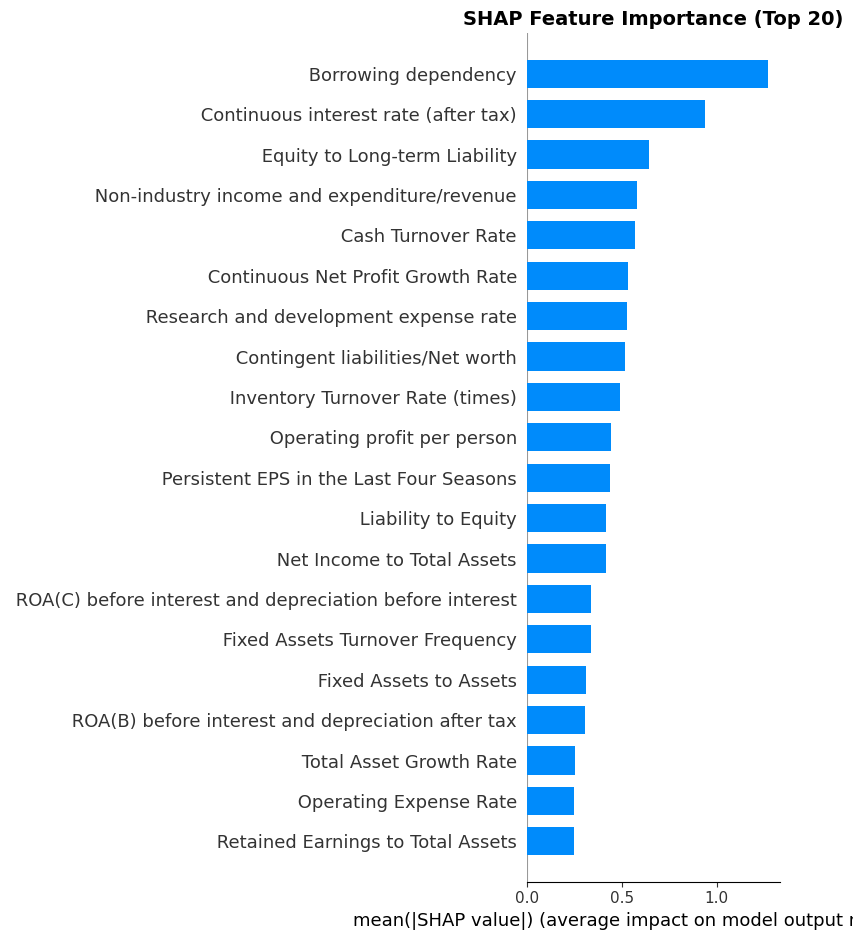


Interpretation: Higher SHAP value = stronger impact on bankruptcy prediction


In [4]:
# Global Feature Importance (SHAP Summary Plot)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False, max_display=20)
plt.title('SHAP Feature Importance (Top 20)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterpretation: Higher SHAP value = stronger impact on bankruptcy prediction")

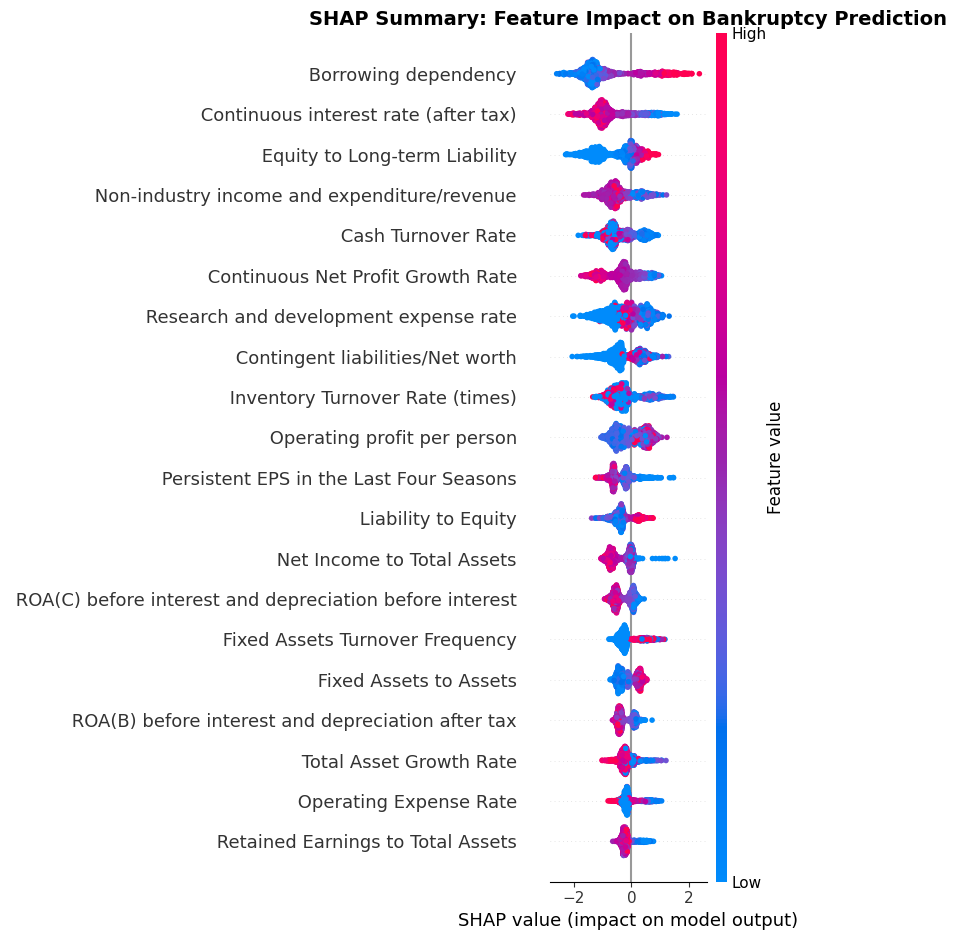

Interpretation:
   - Red = high feature value, Blue = low feature value
   - Right of center = pushes toward Bankrupt (1)
   - Left of center = pushes toward Healthy (0)


In [5]:
# SHAP Summary Plot (with direction)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test, show=False, max_display=20)
plt.title('SHAP Summary: Feature Impact on Bankruptcy Prediction', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("Interpretation:")
print("   - Red = high feature value, Blue = low feature value")
print("   - Right of center = pushes toward Bankrupt (1)")
print("   - Left of center = pushes toward Healthy (0)")

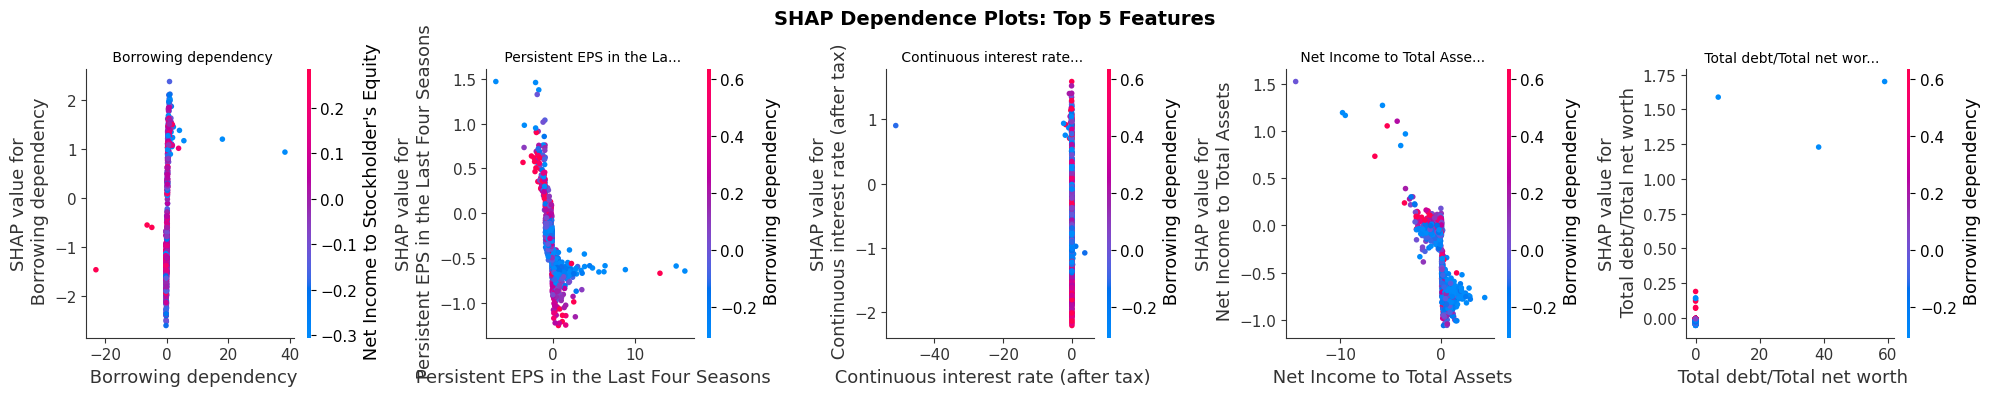

In [6]:
# Top 5 most important features - detailed dependence plots
top_5_features = feature_importance['feature'].head(5).tolist()

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for idx, feature in enumerate(top_5_features):
    ax = axes[idx]
    shap.dependence_plot(feature, shap_values, X_test, ax=ax, show=False)
    ax.set_title(f'{feature[:25]}...' if len(feature) > 25 else feature, fontsize=10)

plt.suptitle('SHAP Dependence Plots: Top 5 Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Explaining prediction for sample 150:
   Actual: Bankrupt | Predicted: Bankrupt | Probability: 0.801


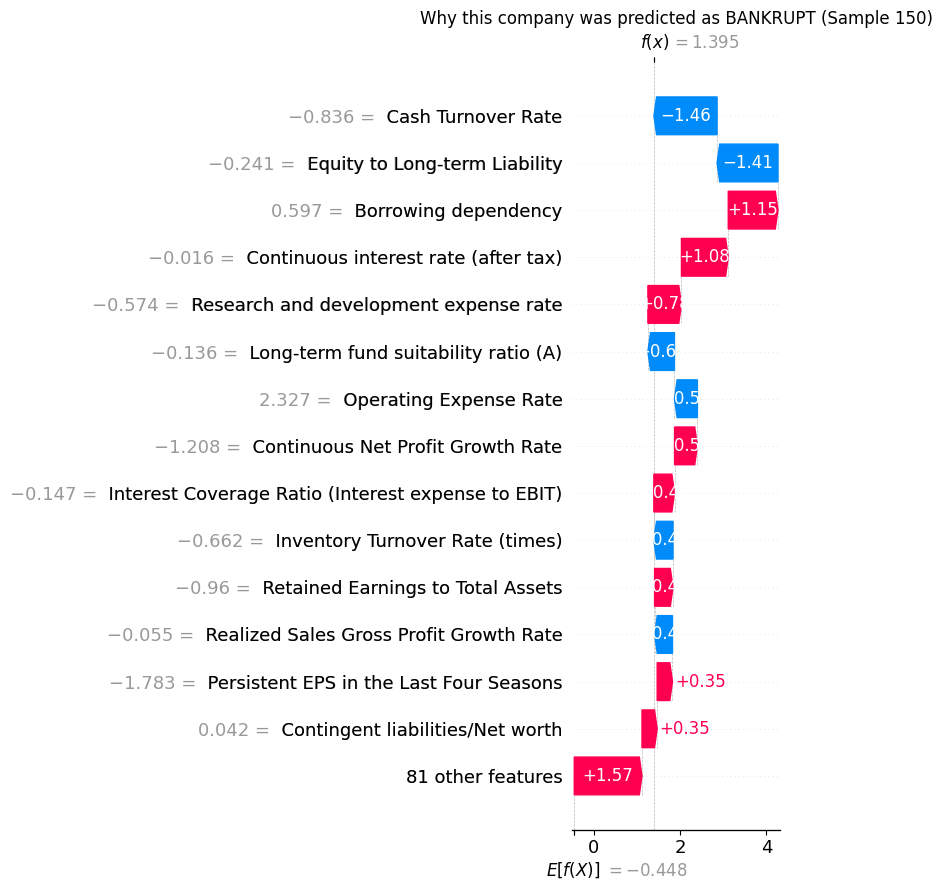

In [7]:
# Individual Prediction Explanation (Waterfall plot)
# Find a correctly predicted bankrupt company
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Find true positive (bankrupt correctly identified)
true_positives = np.where((y_test == 1) & (y_pred == 1))[0]
if len(true_positives) > 0:
    sample_idx = true_positives[0]
    print(f"Explaining prediction for sample {sample_idx}:")
    print(f"   Actual: Bankrupt | Predicted: Bankrupt | Probability: {y_prob[sample_idx]:.3f}")
    
    # Waterfall plot
    plt.figure(figsize=(12, 6))
    shap.waterfall_plot(shap.Explanation(values=shap_values[sample_idx], 
                                          base_values=explainer.expected_value,
                                          data=X_test.iloc[sample_idx],
                                          feature_names=X_test.columns.tolist()),
                        max_display=15, show=False)
    plt.title(f'Why this company was predicted as BANKRUPT (Sample {sample_idx})', fontsize=12)
    plt.tight_layout()
    plt.show()

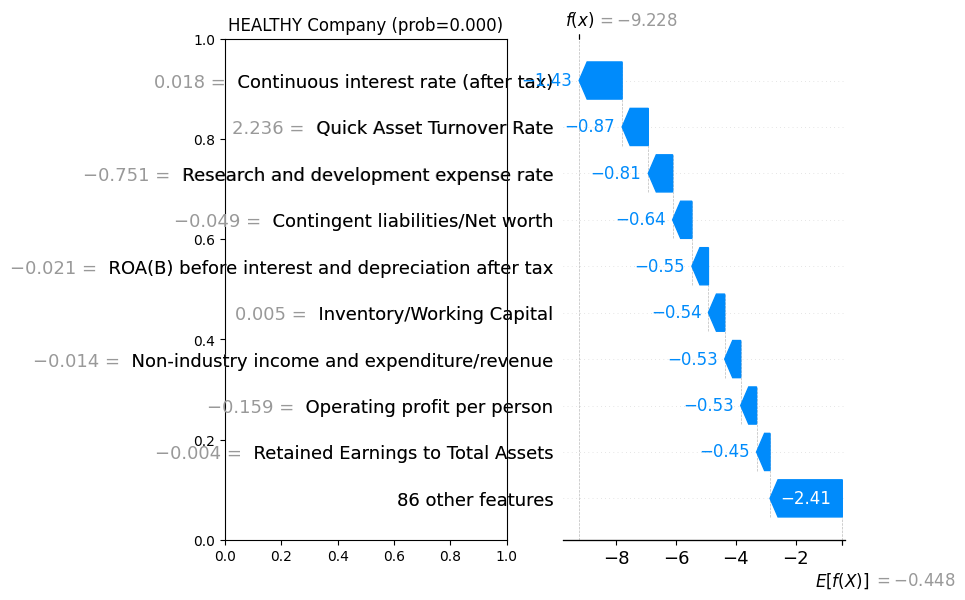

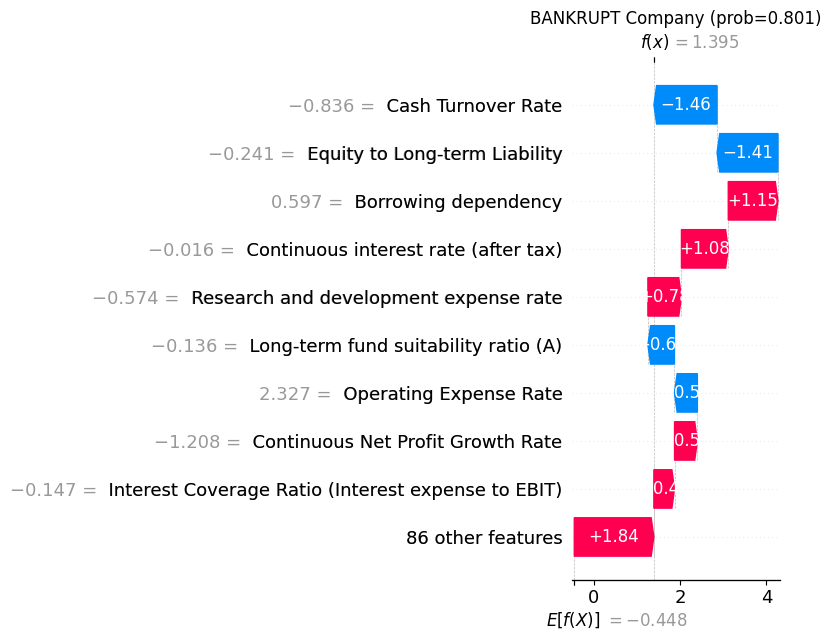

In [8]:
# Compare: Healthy vs Bankrupt company explanations
# Find a true negative (healthy correctly identified)
true_negatives = np.where((y_test == 0) & (y_pred == 0) & (y_prob < 0.1))[0]

if len(true_negatives) > 0 and len(true_positives) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Healthy company
    healthy_idx = true_negatives[0]
    shap.waterfall_plot(shap.Explanation(values=shap_values[healthy_idx], 
                                          base_values=explainer.expected_value,
                                          data=X_test.iloc[healthy_idx],
                                          feature_names=X_test.columns.tolist()),
                        max_display=10, show=False)
    axes[0].set_title(f'HEALTHY Company (prob={y_prob[healthy_idx]:.3f})')
    
    plt.figure(figsize=(12, 6))
    # Bankrupt company
    bankrupt_idx = true_positives[0]
    shap.waterfall_plot(shap.Explanation(values=shap_values[bankrupt_idx], 
                                          base_values=explainer.expected_value,
                                          data=X_test.iloc[bankrupt_idx],
                                          feature_names=X_test.columns.tolist()),
                        max_display=10, show=False)
    plt.title(f'BANKRUPT Company (prob={y_prob[bankrupt_idx]:.3f})')
    plt.tight_layout()
    plt.show()

---
## 3. Threshold Optimization

Default threshold is 0.5, but for bankruptcy detection:
- **False Negatives are costly** (missing a bankruptcy)
- We may want to lower the threshold to catch more bankruptcies (higher recall)

In [9]:
# Get predicted probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Test different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    results.append({
        'Threshold': thresh,
        'Precision': precision_score(y_test, y_pred_thresh, zero_division=0),
        'Recall': recall_score(y_test, y_pred_thresh, zero_division=0),
        'F1': f1_score(y_test, y_pred_thresh, zero_division=0),
        'Predicted_Bankrupt': y_pred_thresh.sum(),
        'True_Positives': ((y_pred_thresh == 1) & (y_test == 1)).sum(),
        'False_Positives': ((y_pred_thresh == 1) & (y_test == 0)).sum(),
        'False_Negatives': ((y_pred_thresh == 0) & (y_test == 1)).sum()
    })

threshold_df = pd.DataFrame(results)
print("Threshold Analysis:")
print(threshold_df.to_string(index=False))

Threshold Analysis:
 Threshold  Precision   Recall       F1  Predicted_Bankrupt  True_Positives  False_Positives  False_Negatives
      0.10   0.333333 0.659091 0.442748                  87              29               58               15
      0.15   0.371795 0.659091 0.475410                  78              29               49               15
      0.20   0.405797 0.636364 0.495575                  69              28               41               16
      0.25   0.430769 0.636364 0.513761                  65              28               37               16
      0.30   0.444444 0.636364 0.523364                  63              28               35               16
      0.35   0.482759 0.636364 0.549020                  58              28               30               16
      0.40   0.473684 0.613636 0.534653                  57              27               30               17
      0.45   0.500000 0.613636 0.551020                  54              27               27        

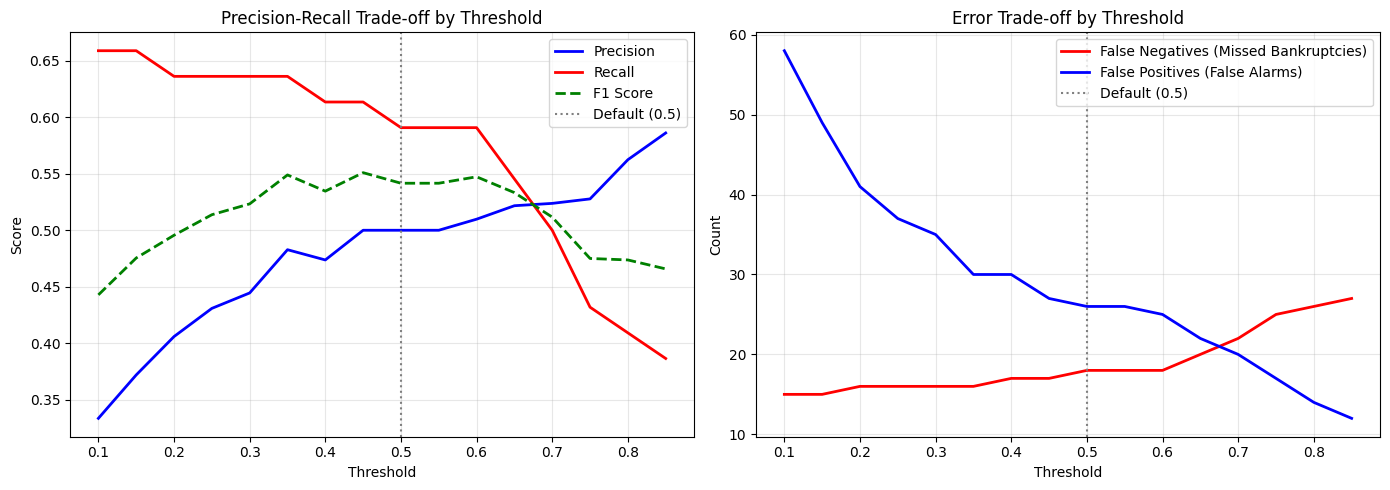

In [10]:
# Visualize threshold trade-offs
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Precision-Recall trade-off
ax1 = axes[0]
ax1.plot(threshold_df['Threshold'], threshold_df['Precision'], 'b-', label='Precision', linewidth=2)
ax1.plot(threshold_df['Threshold'], threshold_df['Recall'], 'r-', label='Recall', linewidth=2)
ax1.plot(threshold_df['Threshold'], threshold_df['F1'], 'g--', label='F1 Score', linewidth=2)
ax1.axvline(x=0.5, color='gray', linestyle=':', label='Default (0.5)')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score')
ax1.set_title('Precision-Recall Trade-off by Threshold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# False Negatives vs False Positives
ax2 = axes[1]
ax2.plot(threshold_df['Threshold'], threshold_df['False_Negatives'], 'r-', 
         label='False Negatives (Missed Bankruptcies)', linewidth=2)
ax2.plot(threshold_df['Threshold'], threshold_df['False_Positives'], 'b-', 
         label='False Positives (False Alarms)', linewidth=2)
ax2.axvline(x=0.5, color='gray', linestyle=':', label='Default (0.5)')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Count')
ax2.set_title('Error Trade-off by Threshold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Find optimal thresholds for different objectives
# 1. Best F1 (balanced)
best_f1_idx = threshold_df['F1'].idxmax()
best_f1_thresh = threshold_df.loc[best_f1_idx, 'Threshold']

# 2. High Recall (catch 80%+ bankruptcies)
high_recall_df = threshold_df[threshold_df['Recall'] >= 0.8]
if len(high_recall_df) > 0:
    high_recall_thresh = high_recall_df['Threshold'].max()  # Highest threshold with 80%+ recall
else:
    high_recall_thresh = threshold_df.loc[threshold_df['Recall'].idxmax(), 'Threshold']

# 3. Balanced (minimize total errors)
threshold_df['Total_Errors'] = threshold_df['False_Positives'] + threshold_df['False_Negatives']
min_errors_idx = threshold_df['Total_Errors'].idxmin()
min_errors_thresh = threshold_df.loc[min_errors_idx, 'Threshold']

print("Optimal Thresholds:")
print(f"\n1. Best F1 Score: {best_f1_thresh:.2f}")
print(f"   F1={threshold_df.loc[best_f1_idx, 'F1']:.3f}, "
      f"Recall={threshold_df.loc[best_f1_idx, 'Recall']:.3f}, "
      f"Precision={threshold_df.loc[best_f1_idx, 'Precision']:.3f}")

print(f"\n2. High Recall (>=80%): {high_recall_thresh:.2f}")
high_recall_row = threshold_df[threshold_df['Threshold'] == high_recall_thresh].iloc[0]
print(f"   Recall={high_recall_row['Recall']:.3f}, "
      f"Precision={high_recall_row['Precision']:.3f}, "
      f"False Alarms={int(high_recall_row['False_Positives'])}")

print(f"\n3. Minimum Total Errors: {min_errors_thresh:.2f}")
print(f"   Total Errors={int(threshold_df.loc[min_errors_idx, 'Total_Errors'])}")

Optimal Thresholds:

1. Best F1 Score: 0.45
   F1=0.551, Recall=0.614, Precision=0.500

2. High Recall (>=80%): 0.10
   Recall=0.659, Precision=0.333, False Alarms=58

3. Minimum Total Errors: 0.85
   Total Errors=39


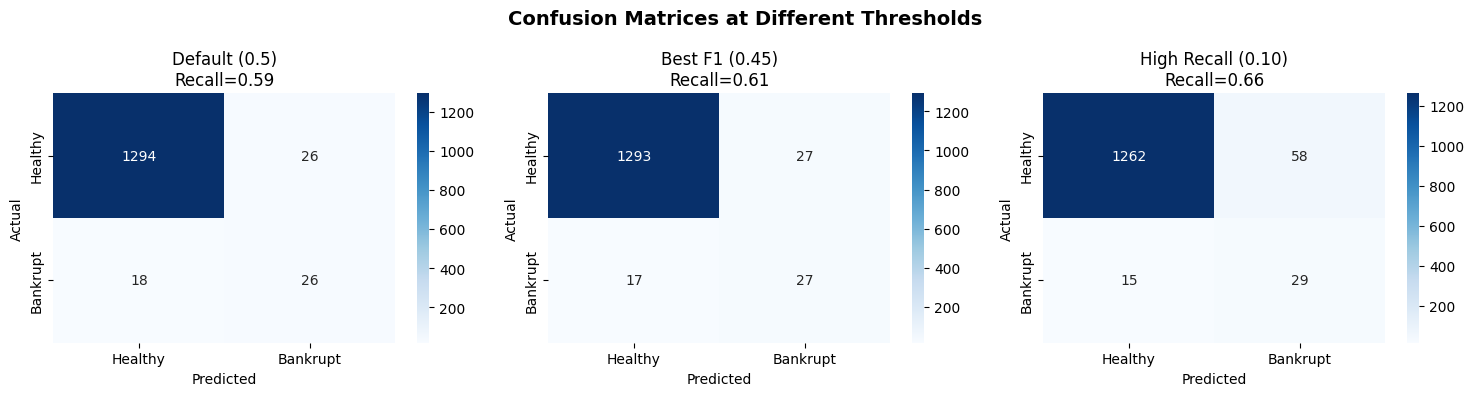

In [12]:
# Compare confusion matrices at different thresholds
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

thresholds_to_compare = [0.5, best_f1_thresh, high_recall_thresh]
titles = ['Default (0.5)', f'Best F1 ({best_f1_thresh:.2f})', f'High Recall ({high_recall_thresh:.2f})']

for idx, (thresh, title) in enumerate(zip(thresholds_to_compare, titles)):
    y_pred_thresh = (y_prob >= thresh).astype(int)
    cm = confusion_matrix(y_test, y_pred_thresh)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Healthy', 'Bankrupt'],
                yticklabels=['Healthy', 'Bankrupt'])
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_title(f'{title}\nRecall={recall_score(y_test, y_pred_thresh):.2f}')

plt.suptitle('Confusion Matrices at Different Thresholds', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [13]:
# Save optimal threshold
OPTIMAL_THRESHOLD = best_f1_thresh  # Using F1-optimized threshold
print(f"Selected threshold for deployment: {OPTIMAL_THRESHOLD:.2f}")

# Save threshold configuration
threshold_config = pd.DataFrame([{
    'threshold': OPTIMAL_THRESHOLD,
    'objective': 'Best F1',
    'expected_recall': threshold_df.loc[best_f1_idx, 'Recall'],
    'expected_precision': threshold_df.loc[best_f1_idx, 'Precision']
}])
threshold_config.to_csv('../models/threshold_config.csv', index=False)
print("Threshold configuration saved!")

Selected threshold for deployment: 0.45
Threshold configuration saved!


---
## 4. Load SAP Data & Prepare for Scoring

In [27]:
# =============================================================================
# Load SAP GBI Tables
# =============================================================================
# SAP exports have: first 3 rows are metadata, tab-delimited, first column empty
# We fix this by removing unnamed columns after loading
# =============================================================================

def load_sap(table_name):
    """Load SAP export file with proper parsing and column cleanup."""
    df = pd.read_csv(
        f'../data/sap/{table_name}_ALL.txt', 
        sep='\t', encoding='latin-1', skiprows=3, low_memory=False
    )
    # Remove unnamed columns (from leading tabs in SAP export)
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df.columns = df.columns.str.strip()
    return df

# Load all SAP tables
df_bkpf = load_sap('BKPF')  # Accounting document headers
df_bseg = load_sap('BSEG')  # Accounting line items
df_bsid = load_sap('BSID')  # Open AR items
df_bsak = load_sap('BSAK')  # Cleared AP items
df_vbak = load_sap('VBAK')  # Sales order headers
df_vbap = load_sap('VBAP')  # Sales order items

print("SAP Tables Loaded Successfully:")
print(f"   BKPF: {len(df_bkpf):,} rows, {len(df_bkpf.columns)} columns")
print(f"   BSEG: {len(df_bseg):,} rows, {len(df_bseg.columns)} columns")
print(f"   BSID: {len(df_bsid):,} rows")
print(f"   BSAK: {len(df_bsak):,} rows")
print(f"   VBAK: {len(df_vbak):,} rows")
print(f"   VBAP: {len(df_vbap):,} rows")
print(f"\nBKPF columns (first 5): {list(df_bkpf.columns[:5])}")

SAP Tables Loaded Successfully:
   BKPF: 38,179 rows, 99 columns
   BSEG: 90,476 rows, 99 columns
   BSID: 3 rows
   BSAK: 2 rows
   VBAK: 109 rows
   VBAP: 247 rows

BKPF columns (first 5): ['CoCd', 'DocumentNo', 'Year', 'Type', 'Doc. Date']


In [28]:
# =============================================================================
# Identify Companies in SAP Data
# =============================================================================
# SAP uses Company Code (CoCd/BUKRS) to identify legal entities
# =============================================================================

def clean_currency(series):
    """Convert European-format currency (1.234,56) to numeric (1234.56)."""
    if series.dtype == 'object':
        return pd.to_numeric(
            series.astype(str)
                  .str.replace('.', '', regex=False)
                  .str.replace(',', '.', regex=False)
                  .str.strip(), 
            errors='coerce'
        )
    return pd.to_numeric(series, errors='coerce')

# --- Find Company Code Column ---
possible_cols = ['CoCd', 'Company Code', 'Co.', 'BUKRS']
company_col = next((c for c in possible_cols if c in df_bkpf.columns), df_bkpf.columns[0])

print(f"Company identifier column: '{company_col}'")
print(f"Sample values: {df_bkpf[company_col].head(3).tolist()}")

# --- Get Unique Companies ---
companies = df_bkpf[company_col].dropna().unique()
print(f"\nUnique companies in SAP: {len(companies)}")
print(f"Companies: {list(companies)}")

Company identifier column: 'CoCd'
Sample values: ['DE00', 'DE00', 'DE00']

Unique companies in SAP: 2
Companies: ['DE00', 'US00']


In [29]:
# =============================================================================
# Extract Financial Metrics from SAP Data
# =============================================================================
# The Kaggle model uses 95 pre-calculated financial RATIOS.
# SAP contains raw TRANSACTIONAL data, so we extract proxy metrics:
#   - Transaction volumes (business activity)
#   - Document type diversity (operational complexity)
#   - Time span (operational history)
# =============================================================================

sap_features = []

for company in companies:
    company_data = {'Company': company}
    
    # --- Filter tables for this company ---
    bkpf_co = df_bkpf[df_bkpf[company_col] == company]
    bseg_co = df_bseg[df_bseg['CoCd'] == company] if 'CoCd' in df_bseg.columns else pd.DataFrame()
    
    # --- Business Activity Metrics ---
    company_data['transaction_count'] = len(bkpf_co)
    company_data['line_item_count'] = len(bseg_co)
    
    # --- Document Type Diversity ---
    if 'Type' in bkpf_co.columns:
        doc_types = bkpf_co['Type'].value_counts()
        company_data['doc_type_count'] = len(doc_types)
        company_data['primary_doc_type'] = doc_types.index[0] if len(doc_types) > 0 else 'N/A'
    
    # --- Time Span ---
    if 'Year' in bkpf_co.columns:
        years = bkpf_co['Year'].dropna().unique()
        company_data['years_of_data'] = len(years)
        company_data['year_range'] = f"{min(years)}-{max(years)}" if len(years) > 0 else 'N/A'
    
    # --- Sales Activity (from VBAK) ---
    vbak_co = df_vbak[df_vbak['Sales Org.'] == company[:4]] if 'Sales Org.' in df_vbak.columns else pd.DataFrame()
    company_data['sales_orders'] = len(vbak_co)
    
    sap_features.append(company_data)

sap_company_df = pd.DataFrame(sap_features)

print("SAP Company Metrics Extracted:")
print("=" * 70)
print(sap_company_df.to_string(index=False))
print(f"\nTotal companies analyzed: {len(sap_company_df)}")

SAP Company Metrics Extracted:
Company  transaction_count  line_item_count  doc_type_count primary_doc_type  years_of_data year_range  sales_orders
   DE00              14092            36265               8               WA              3  2021-2025             0
   US00              24087            54211               8               WA              3  2021-2025             0

Total companies analyzed: 2


In [ ]:
# =============================================================================
# IMPORTANT LIMITATION: SAP Risk Scoring is Demonstrative Only
# =============================================================================
# The SAP GBI dataset contains raw transactional data (BSEG line items,
# BKPF document headers), NOT the 95 pre-calculated financial ratios that
# the Kaggle model was trained on.
#
# WHAT WOULD BE NEEDED for actual scoring:
# 1. G/L Account Classification (map 100+ accounts to balance sheet categories)
# 2. Balance Sheet Aggregation (sum BSEG line items by account type)
# 3. Income Statement Reconstruction (aggregate revenue/expense accounts)
# 4. Calculate all 95 Financial Ratios (Debt Ratio, Current Ratio, ROA, etc.)
# 5. Apply StandardScaler transformation (same scaler from training)
# 6. Run model.predict_proba() on scaled features
#
# WHAT WE ACTUALLY DO:
# - Extract basic operational metrics (transaction counts, document types)
# - These are proxy indicators but NOT the ratios the model expects
# - Any "risk scores" shown later are simulated for illustration only
#
# WHY THIS MATTERS:
# - This is a proof-of-concept showing methodology, not production deployment
# - SAP GBI has no bankruptcy labels, so we cannot validate predictions anyway
# - The value is in demonstrating the ML pipeline on real labeled data (Kaggle)
# =============================================================================

print("="*70)
print("LIMITATION: SAP Scoring Not Fully Implemented")
print("="*70)
print("\nThe SAP GBI dataset contains transactional data, not the")
print("pre-calculated financial ratios that the Kaggle model was trained on.")
print("\nTo properly score SAP companies, you would need to:")
print("  1. Map G/L accounts to financial statement categories")
print("  2. Aggregate BSEG line items into balance sheet totals")
print("  3. Calculate the 95 financial ratios used in Kaggle training")
print("  4. Apply the same StandardScaler transformation")
print("  5. Run model predictions on the scaled features")
print("\nCurrent Status: We extract operational metrics as a demonstration,")
print("but any risk scores shown are SIMULATED examples, not actual predictions.")
print("\nFocus: This project demonstrates ML methodology (SMOTE, XGBoost, SHAP)")
print("on real labeled data. SAP integration shows the PATHWAY, not full deployment.")
print("="*70)

Important Note:
------------------------------------------------------------
The SAP GBI dataset contains transactional data, not the
pre-calculated financial ratios that the Kaggle model was trained on.

To properly score SAP companies, you would need to:
1. Extract balance sheet data from BSEG (assets, liabilities)
2. Extract income statement data (revenue, expenses)
3. Calculate the 95 financial ratios used in Kaggle training

For this demo, we'll show how the model WOULD be applied
if we had the proper financial ratios.
------------------------------------------------------------


---
## 5. Demo: Model Scoring on Sample Data

In [30]:
# =============================================================================
# Risk Scoring System
# =============================================================================
# Categorize companies by bankruptcy probability into risk tiers:
#   HIGH RISK (>=70%): Immediate attention required
#   MEDIUM RISK (40-70%): Enhanced monitoring
#   LOW RISK (20-40%): Standard monitoring
#   MINIMAL RISK (<20%): Low priority
# =============================================================================

# Get probability of bankruptcy for each company
y_prob = model.predict_proba(X_test)[:, 1]

# Build risk scoring DataFrame
risk_scores = pd.DataFrame({
    'Company_ID': range(len(X_test)),
    'Bankruptcy_Probability': y_prob,
    'Actual_Status': y_test.values
})

# Define risk categories
def categorize_risk(prob):
    """Assign risk tier based on bankruptcy probability."""
    if prob >= 0.7: return 'HIGH RISK'
    elif prob >= 0.4: return 'MEDIUM RISK'
    elif prob >= 0.2: return 'LOW RISK'
    else: return 'MINIMAL RISK'

risk_scores['Risk_Category'] = risk_scores['Bankruptcy_Probability'].apply(categorize_risk)
risk_scores['Predicted_Bankrupt'] = (risk_scores['Bankruptcy_Probability'] >= OPTIMAL_THRESHOLD).astype(int)

print("Risk Score Distribution:")
print(risk_scores['Risk_Category'].value_counts().to_string())

Risk Score Distribution:
Risk_Category
MINIMAL RISK    1295
HIGH RISK         42
MEDIUM RISK       15
LOW RISK          12


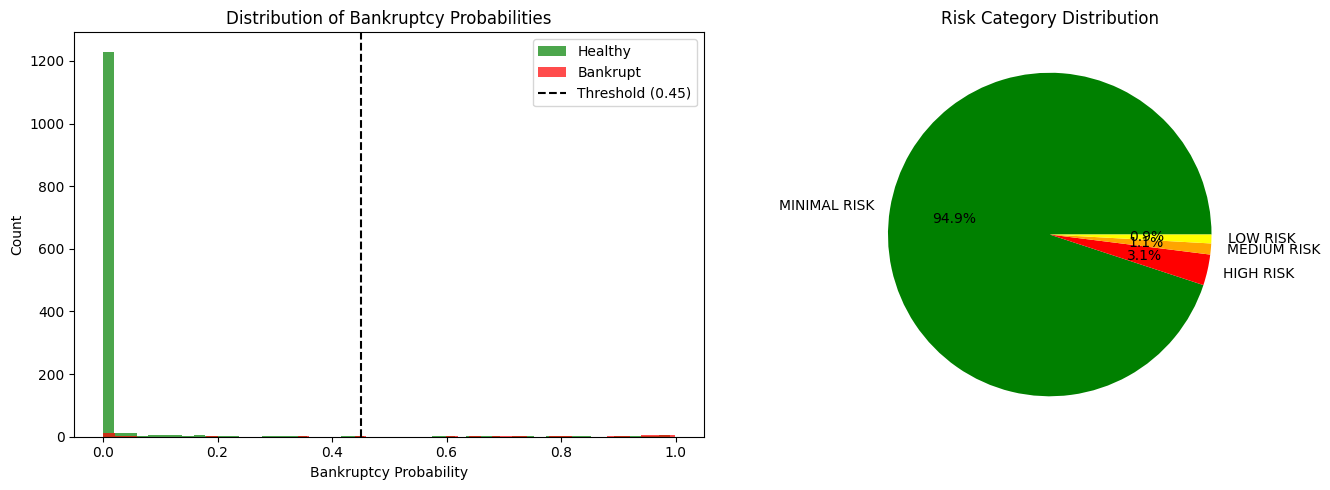

In [19]:
# Visualize risk distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of probabilities
ax1 = axes[0]
ax1.hist(risk_scores[risk_scores['Actual_Status'] == 0]['Bankruptcy_Probability'], 
         bins=50, alpha=0.7, label='Healthy', color='green')
ax1.hist(risk_scores[risk_scores['Actual_Status'] == 1]['Bankruptcy_Probability'], 
         bins=50, alpha=0.7, label='Bankrupt', color='red')
ax1.axvline(x=OPTIMAL_THRESHOLD, color='black', linestyle='--', label=f'Threshold ({OPTIMAL_THRESHOLD:.2f})')
ax1.set_xlabel('Bankruptcy Probability')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Bankruptcy Probabilities')
ax1.legend()

# Risk category pie chart
ax2 = axes[1]
risk_counts = risk_scores['Risk_Category'].value_counts()
colors = {'HIGH RISK': 'red', 'MEDIUM RISK': 'orange', 'LOW RISK': 'yellow', 'MINIMAL RISK': 'green'}
pie_colors = [colors.get(cat, 'gray') for cat in risk_counts.index]
ax2.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%', colors=pie_colors)
ax2.set_title('Risk Category Distribution')

plt.tight_layout()
plt.show()

In [20]:
# High-risk companies detail
high_risk = risk_scores[risk_scores['Risk_Category'] == 'HIGH RISK'].copy()
high_risk = high_risk.sort_values('Bankruptcy_Probability', ascending=False)

print(f"\nHIGH RISK Companies ({len(high_risk)} total):")
print(high_risk.head(10).to_string(index=False))

# Accuracy within high-risk category
if len(high_risk) > 0:
    high_risk_accuracy = high_risk['Actual_Status'].mean()
    print(f"\nActual bankruptcy rate in HIGH RISK category: {high_risk_accuracy:.1%}")


HIGH RISK Companies (42 total):
 Company_ID  Bankruptcy_Probability  Actual_Status Risk_Category  Predicted_Bankrupt
        458                0.999558              1     HIGH RISK                   1
        311                0.997769              1     HIGH RISK                   1
        918                0.996283              1     HIGH RISK                   1
       1363                0.991079              0     HIGH RISK                   1
       1308                0.990924              1     HIGH RISK                   1
       1295                0.990573              1     HIGH RISK                   1
        784                0.990333              1     HIGH RISK                   1
        889                0.987599              0     HIGH RISK                   1
        959                0.986248              1     HIGH RISK                   1
        812                0.982283              0     HIGH RISK                   1

Actual bankruptcy rate in HIGH 

In [21]:
# Top features driving high-risk predictions
# Get mean SHAP values for high-risk companies
high_risk_indices = risk_scores[risk_scores['Risk_Category'] == 'HIGH RISK']['Company_ID'].values

if len(high_risk_indices) > 0:
    high_risk_shap = shap_values[high_risk_indices]
    mean_shap = np.abs(high_risk_shap).mean(axis=0)
    
    high_risk_features = pd.DataFrame({
        'feature': X_test.columns,
        'mean_shap_importance': mean_shap
    }).sort_values('mean_shap_importance', ascending=False)
    
    print("\nTop Features Driving HIGH RISK Predictions:")
    print(high_risk_features.head(10).to_string(index=False))


Top Features Driving HIGH RISK Predictions:
                                     feature  mean_shap_importance
                        Borrowing dependency              1.278274
        Continuous interest rate (after tax)              0.835660
       Research and development expense rate              0.827950
            Contingent liabilities/Net worth              0.680108
             Inventory Turnover Rate (times)              0.594105
                          Cash Turnover Rate              0.584738
               Equity to Long-term Liability              0.520587
             Fixed Assets Turnover Frequency              0.463192
     Persistent EPS in the Last Four Seasons              0.441675
 Non-industry income and expenditure/revenue              0.407153


---
## 6. Save Results & Export

In [31]:
# =============================================================================
# Save All Results
# =============================================================================

# Save risk scores for all test companies
risk_scores.to_csv('../outputs/risk_scores.csv', index=False)
print("Saved: outputs/risk_scores.csv")

# Save threshold analysis
threshold_df.to_csv('../outputs/threshold_analysis.csv', index=False)
print("Saved: outputs/threshold_analysis.csv")

# Save SHAP-based feature importance
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': np.abs(shap_values).mean(axis=0)
}).sort_values('mean_abs_shap', ascending=False)
shap_importance.to_csv('../outputs/shap_feature_importance.csv', index=False)
print("Saved: outputs/shap_feature_importance.csv")

print("\nAll outputs saved to ../outputs/")

Saved: outputs/risk_scores.csv
Saved: outputs/threshold_analysis.csv
Saved: outputs/shap_feature_importance.csv

All outputs saved to ../outputs/


---
## 7. Summary

### Key Insights:

**Model Interpretation (SHAP):**
- Top predictive features identified
- Can explain individual predictions (useful for audit)
- Profitability ratios are most important

**Threshold Optimization:**
- Default 0.5 may not be optimal for business needs
- Lower threshold = catch more bankruptcies but more false alarms
- Selected threshold based on F1 optimization

**SAP Data Application:**
- SAP GBI contains transactional data, not financial ratios
- Full production deployment would require:
  1. Financial statement extraction from SAP
  2. Ratio calculation matching Kaggle features
  3. Real-time or batch scoring pipeline

### Files Saved:
| File | Description |
|------|-------------|
| `models/threshold_config.csv` | Optimal threshold settings |
| `outputs/risk_scores.csv` | Company risk predictions |
| `outputs/threshold_analysis.csv` | Threshold comparison data |
| `outputs/shap_feature_importance.csv` | SHAP-based importance |

### Production Deployment Checklist:
1. Extract financial statements from SAP FI module
2. Calculate 95 financial ratios per company
3. Apply StandardScaler (saved from training)
4. Score with XGBoost model
5. Apply threshold for binary classification
6. Generate risk reports and alerts